# SPT Model - Debug

In [1]:
from __future__ import print_function, division
from IPython.core.display import display, HTML
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from scipy import interpolate
from multiprocessing import Pool
cosmology.setCosmology('WMAP9')

import numpy as np
import pandas as pd
import emcee
import pandas as pd
import time
import os
import sys
from scipy.optimize import minimize
import scipy.stats
import math
import matplotlib.pyplot as plt
import pylab as plt
import corner

In [2]:
%matplotlib inline

In [3]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_chisi(zeta, xi):
    res = np.exp(-(xi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res

def prob_lbd_hat(x, mean , std):
    res = gaussian(x, mean , std)
    return res

def prob_mass(zeta, mass, z, params):
    params = A_sze, B_sze, C_sze, scatter_sze
    ln_zeta_pred = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, z)
    ln_prob = -0.5*((np.log(zeta)-ln_zeta_pred)/scatter_sze)**2
    return ln_prob
    
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,1)
    return ilo, iup

In [4]:
def log_likelihood(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_likelihood(theta, ix))
    p = np.array(probs)#/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [5]:
def _likelihood(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # forgot the mass
    redshift_i = redshift[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    #p_lbd_hat_conv = prob_lbd_hat_conv[ix]
    llo, lup = list(lbd_indices_vec[ix])
    #llo, lup = 0, len(lbdvec)#list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, redshift_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, redshift_i)
    halo_mass_func = halo_mass_function2(redshift_i)
    
    ln_lbd_pred = ln_lbd_pred[:,np.newaxis,np.newaxis]
    ln_zeta_pred= ln_zeta_pred[:,np.newaxis,np.newaxis]
    hmf = halo_mass_func[:,np.newaxis,np.newaxis]
    
    # the logNormal Distribution
    lp_lbd_zeta = compute_log_pLbdZeta(ll[:,clo:cup,llo:lup], zz[:,clo:cup,llo:lup],
                                      scatter_lambda, scatter_sze, rho,
                                      ln_lbd_pred, ln_zeta_pred)
    dN_lbd_zeta = np.exp(lp_lbd_zeta)
    
    # integrate over M
    #norm = float(norm_function(redshift_i))
    p_lbd_zeta = np.trapz(dN_lbd_zeta*hmf, x=mvec, axis=0)#/norm

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    
    # integrate over lambda
    norm = np.trapz(p_lbd, x=lbdvec[llo:lup])
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p/norm

In [6]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')

halo_mass_function = np.vectorize(_halo_mass_function)

In [7]:
def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    
    lp += 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = -1.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp += 0. if (theta_values[-1] > 0) else -np.inf
    return lp

In [8]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [9]:
#### DEFINING THE FUNCTION PRIOR ####

SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

## gaussian priors on lambda with 3 sigma from the true params
Lambda_Priors = {'A_lambda':[76.9, 3*8.2], 'B_lambda':[1.020, 5*0.080],'C_lambda':[0.23, 5*0.16],
             'scatter_lambda':[0.23, 3.0*0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

def logprior(theta):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho >= -1.) and (rho <= 1.)) else -np.inf
    return lp + lp_lambda + lp_sze

In [10]:
def logposterior(theta, indices):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    
    ll = log_likelihood(theta, indices)# + lp
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

In [11]:
def compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
                         ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = scatter_sze
    s_lambda = scatter_lambda
    s_lambda_inv = np.where(s_lambda<=eps, np.inf, 1/s_lambda)
    s_zeta_inv = np.where(s_zeta<=eps, np.inf, 1/s_zeta)
    
    # avoid error messages
    rho2 = (1-rho**2)
    rho_inv = np.where(rho2<=eps, np.inf, 1/rho2)
    cov2 = (s_lambda)**(2)*(s_zeta)**(2)*rho2
    
    additional_cov = (-0.5)*np.log(np.pi*cov2)

    lbd_std = (np.log(Lambda) - ln_lbd_pred)*s_lambda_inv
    zeta_std = (np.log(Zeta) - ln_zeta_pred)*s_zeta_inv

    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2.

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    
    # total likelihood
    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov

    return lp_total_m

In [12]:
### Grid Setting
nCores = 32
Nzeta = 50 # Previously 100
Nlbd = 100 # Previously 200
Nmass = 100 # Previously 100
Nz = 100
alpha = 0.001

### MCMC Setup
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
Nburnin = 1000 # number of burn-in samples
Nsamples = 10000 # number of final posterior samples
walkers = 64
ndims = len(theta_true)
guess = (np.array(theta_true)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# global variables
M0 = 3e14
Ez0 = E(0)

## Fake Data Analysis

In [13]:
### CURRENT FAKE DATA FILE ###
infile = 'fake_data_Jul4.csv'

df = pd.read_csv(infile)
mask = (df['lambda']>2.)&(df['zeta']>0.)
ix = np.where(mask)[0]
Np = ix.size
    
# Set Variables
indices = np.arange(Np,dtype=int)
yerr = 0.05*(df['lambda'].to_numpy())
redshift = (np.array(df['z']))[ix]
zeta = (np.array(df['zeta']))[ix]
sz_signal = (np.array(df['chisi']))[ix]
_lambda = (np.array(df['lambda_wo_noise']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = np.array(df['M'])[ix]
## LAMBDA ERROR SHOULD BE USED SINCE IT IS THE [ix] VERSION OF YERR
print(_lambda_error)
print(yerr)

[3.4479769  7.36820979 2.33470904 ... 2.43272596 4.14535818 4.03620543]
[3.4479769  7.36820979 2.33470904 ... 2.43272596 4.14535818 4.03620543]


In [14]:
# set up integration vectors
zvec = np.linspace(np.min(redshift), np.max(redshift), Nz)
mvec = np.logspace(13.8, 15.2, Nmass)
lbdvec = np.linspace(0.8*np.min(_lambda), 1.2*np.max(_lambda), Nlbd)
zetavec = np.linspace(1.5, 1.2*np.max(zeta), Nzeta)
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

zz2, mm2 = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm2, zz2), kind='cubic')

print('Vector size')
print('lambda vec',lbdvec.size)
print('zeta vec',zetavec.size)
print('mass vec',mvec.size)
print('Number of points',Np)

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

print("This is prob_lbd_hat_vec shape :", prob_lbd_hat_vec.shape)
print("This is lbd_indices_vec:", lbd_indices_vec[:3])
print("This is zeta_indices_vec shape:", zeta_indices_vec.shape)

Vector size
lambda vec 100
zeta vec 50
mass vec 100
Number of points 1318
This is prob_lbd_hat_vec shape : (1318, 100)
This is lbd_indices_vec: [[ 7 13]
 [22 33]
 [ 3  7]]
This is zeta_indices_vec shape: (1318, 2)


In [15]:
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]
logposterior(theta_true, sel)
print("The value of the logposterior using theta_true and sel: ", logposterior(theta_true, sel))
indices = np.arange(len(mass))
print("The value of the logposterior using theta_true and indicies (STANDARD): ", logposterior(theta_true, indices))

The value of the logposterior using theta_true and sel:  (-300.8616029965712, -0.013446180555555555)
The value of the logposterior using theta_true and indicies (STANDARD):  (-4029.684171144226, -0.013446180555555555)


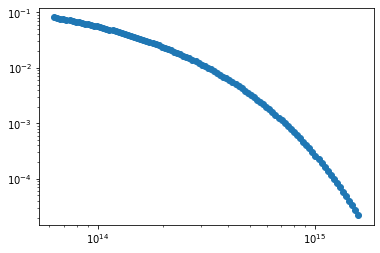

In [16]:
# Copying the below code from the fake/real data section; compatible with older analysis
# from Implementing the SPT Model
# Setting grid for integration

# the second variable is whatever is considered redshift[ix]
# FAKE DATA: redshift = (np.array(df['z']))[ix]
# FAKE DATA USAGE: (np.array(df['z']))[ix]
mm, zz = np.meshgrid(mvec, (np.array(df['z']))[ix])

# unfolding theta
A_lambda, B_lambda, C_lambda, scatter_lambda = theta_true[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta_true[:4]
rho = theta_true[-1]

# calling predictions; 
ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
ln_zeta_pred = (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

halo_mass_func = (halo_mass_function(mm, zz)).T
plt.loglog()
plt.scatter(mvec, halo_mass_func[:,0])

In [17]:
# USING METHOD FROM "Implementing the SPT Model"
# converting std to normal distribution
eps=1e-9
numberOfPoints = 10
# OLD CODE: DON'T REDEFINE ix
#ix = np.where(lambda_chisq>30)[0][:numberOfPoints] # take 10 points
ix = np.where(mask)[0][:numberOfPoints]

z = redshift
chisi = sz_signal
lbd_hat = _lambda
lbd_err = _lambda_error
lbd = lbd_hat[0]
zeta = chisi[0]


s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# defining standirized variables
lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*halo_mass_func

# integrate over M
p_total = np.trapz(p_total_m, x=mvec/M0, axis=0)

In [18]:
p_total[0]

0.0022067414981261704

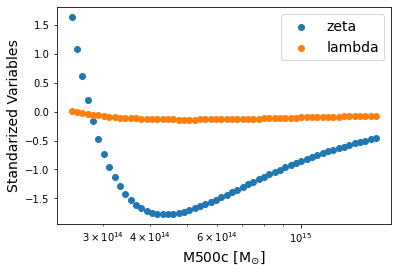

In [19]:
w, = np.where(np.abs(zeta_std[:,0])<2.)
plt.scatter(mvec[w],zeta_std[:,0][w],label='zeta')
plt.scatter(mvec[w],lbd_std[:,0][w],label='lambda')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Standarized Variables',fontsize=14)
plt.legend(fontsize=14)

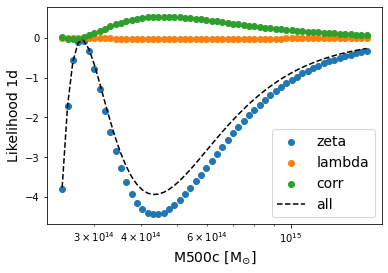

In [20]:
# plt.loglog()
plt.scatter(mvec[w],lp_zeta[:,0][w],label='zeta')
plt.scatter(mvec[w],lp_lbd[:,0][w],label='lambda')
plt.scatter(mvec[w],lp_corr[:,0][w],label='corr')
plt.plot(mvec[w],lp_total_m[:,0][w],label='all',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

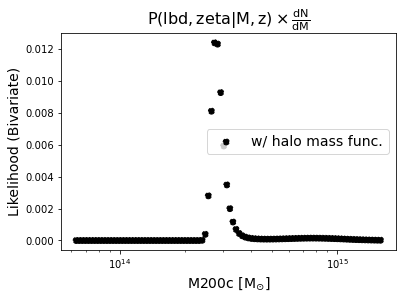

In [21]:
# plt.loglog()
plt.scatter(mvec,p_total_m[:,0],label='w/ halo mass func.',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood (Bivariate)',fontsize=14)
plt.title(r'$\rm P(lbd, zeta| M, z) \times \frac{dN}{dM}$', fontsize=16)
plt.legend(fontsize=14)

In [22]:
ix = np.arange(len(_lambda))[_lambda>0][np.argmax(_lambda[_lambda>0])]

lbd_hat_i = _lambda
lbd_err_i = _lambda_error
chisi_i = sz_signal
z_i = redshift
print(lbd_hat_i)
print(chisi_i)

[ 68.95953803 147.36419572  46.69418077 ...  48.65451912  82.90716351
  80.72410862]
[ 5.20914016 12.06097653  3.65536391 ...  3.52215507  6.39372515
  6.72513345]


In [23]:
# 3-D OPERANDS CANNOT BE BROADCASTED

# ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
# ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
# halo_mass_func = halo_mass_function(mvec, z_i)

# hmf = np.tile(halo_mass_func, (len(lbdvec), len(zetavec), 1)).T
# ln_lbd_pred = np.tile(ln_lbd_pred, (len(lbdvec), len(zetavec), 1)).T
# ln_zeta_pred = np.tile(ln_zeta_pred, (len(lbdvec), len(zetavec), 1)).T
# print(hmf.shape)

In [24]:
# 3-D OPERANDS CANNOT BE BROADCASTED

# # converting std to normal distribution
# s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
# s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# # avoid error messages
# rho_inv = (1-rho**2)
# rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# # # defining standirized variables
# lbd_std = (ll - np.exp(ln_lbd_pred))/s_lambda
# zeta_std = (zz - np.exp(ln_zeta_pred))/s_zeta

# # lbd_likelihood
# lp_lbd  = -rho_inv*lbd_std**2/2 #-((ll-lbd_hat_i)/lbd_err_i)**2/2.

# # zeta likelihood
# lp_zeta = -rho_inv*zeta_std**2/2 #-(chisi_i-np.sqrt(zz**2+3))**2/2.

# # corr likelihod
# lp_corr = rho*rho_inv*lbd_std*zeta_std

# lp_total_m = lp_lbd+lp_zeta+lp_corr
# p_total_m = np.exp(lp_total_m)*hmf#/M0
# #p_total_m = np.where(p_total_m<eps, 0., p_total_m)

# # integrate over M
# p_lbd_zeta = simps(p_total_m, x=mvec, axis=0)

# print(ll.shape)
# print(ln_lbd_pred.shape)

In [26]:
# 3-D OPERANDS CANNOT BE BROADCASTED
# w, = np.where(np.abs(zeta_std[:,0,0])<11.)
# plt.scatter(mvec[w],lp_zeta[:,0,0][w],label='zeta')
# plt.scatter(mvec[w],lp_lbd[:,0,0][w],label='lambda')
# plt.scatter(mvec[w],lp_corr[:,0,0][w],label='corr')
# plt.plot(mvec[w],lp_total_m[:,0,0][w],label='all',color='k',ls='--')
# plt.xscale('log')
# plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
# plt.ylabel('Likelihood 1d',fontsize=14)
# plt.legend(fontsize=14)

## Real Data Analysis

In [27]:
### CURRENT REAL DATA FILE ###
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
ix = np.where(data['LAMBDA_CHISQ']>30)[0]
Np = ix.size
 
# Set Variables
indices = np.arange(Np,dtype=int)
sz_signal = np.array(data['XI'])[ix]
zeta = np.sqrt(sz_signal**2-3)
_lambda = np.array(data['LAMBDA_CHISQ'])[ix]
_lambda_error = np.array(data['LAMBDA_CHISQ_E'])[ix]
redshift = np.array(data['REDSHIFT'])[ix]
mass = np.array(data['M500']*1e14)[ix]

In [28]:
# set up integration vectors
zvec = np.linspace(np.min(redshift), np.max(redshift), Nz)
mvec = np.logspace(13.8, 15.2, Nmass)
lbdvec = np.linspace(0.8*np.min(_lambda), 1.2*np.max(_lambda), Nlbd)
zetavec = np.linspace(1.5, 1.2*np.max(zeta), Nzeta)
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

zz2, mm2 = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm2, zz2), kind='cubic')

print('Vector size')
print('lambda vec',lbdvec.size)
print('zeta vec',zetavec.size)
print('mass vec',mvec.size)
print('Number of points',Np)

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

print("This is prob_lbd_hat_vec shape :", prob_lbd_hat_vec.shape)
print("This is lbd_indices_vec:", lbd_indices_vec[:3])
print("This is zeta_indices_vec shape:", zeta_indices_vec.shape)

Vector size
lambda vec 100
zeta vec 50
mass vec 100
Number of points 266
This is prob_lbd_hat_vec shape : (266, 100)
This is lbd_indices_vec: [[20 34]
 [29 43]
 [14 29]]
This is zeta_indices_vec shape: (266, 2)


In [29]:
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]
logposterior(theta_true, sel)
print("The value of the logposterior using theta_true and sel: ", logposterior(theta_true, sel))
indices = np.arange(len(mass))
print("The value of the logposterior using theta_true and indicies (STANDARD): ", logposterior(theta_true, indices))

The value of the logposterior using theta_true and sel:  (-345.9670661774137, -0.013446180555555555)
The value of the logposterior using theta_true and indicies (STANDARD):  (-941.3979992599593, -0.013446180555555555)


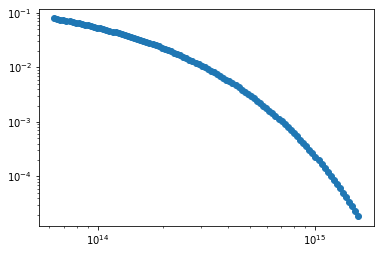

In [30]:
# Copying the below code from the fake/real data section; compatible with older analysis
# from Implementing the SPT Model
# Setting grid for integration

# the second variable is whatever is considered redshift[ix]
# REAL DATA: redshift = np.array(data['REDSHIFT'])[ix]
# REAL DATA USAGE: np.array(data['REDSHIFT'])[ix]
mm, zz = np.meshgrid(mvec, np.array(data['REDSHIFT'])[ix])

# unfolding theta
A_lambda, B_lambda, C_lambda, scatter_lambda = theta_true[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta_true[:4]
rho = theta_true[-1]

# calling predictions; 
ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
ln_zeta_pred = (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

halo_mass_func = (halo_mass_function(mm, zz)).T
plt.loglog()
plt.scatter(mvec, halo_mass_func[:,0])

In [31]:
# USING METHOD FROM "Implementing the SPT Model"
# converting std to normal distribution
eps=1e-9
numberOfPoints = 10
# OLD CODE: DON'T REDEFINE ix
#ix = np.where(lambda_chisq>30)[0][:numberOfPoints] # take 10 points
ix = np.where(mask)[0][:numberOfPoints]

z = redshift
chisi = sz_signal
lbd_hat = _lambda
lbd_err = _lambda_error
lbd = lbd_hat[0]
zeta = chisi[0]


s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# defining standirized variables
lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*halo_mass_func

# integrate over M
p_total = np.trapz(p_total_m, x=mvec/M0, axis=0)

In [32]:
p_total[0]

0.002318524293717598

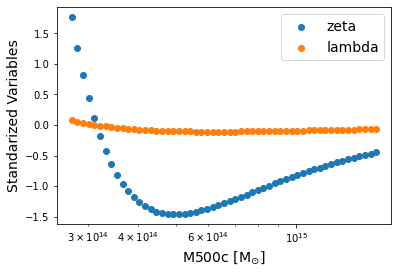

In [33]:
w, = np.where(np.abs(zeta_std[:,0])<2.)
plt.scatter(mvec[w],zeta_std[:,0][w],label='zeta')
plt.scatter(mvec[w],lbd_std[:,0][w],label='lambda')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Standarized Variables',fontsize=14)
plt.legend(fontsize=14)

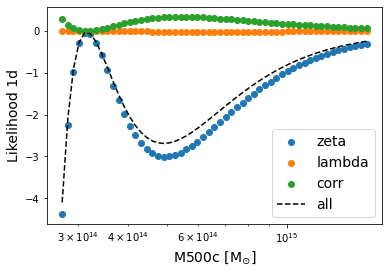

In [34]:
# plt.loglog()
plt.scatter(mvec[w],lp_zeta[:,0][w],label='zeta')
plt.scatter(mvec[w],lp_lbd[:,0][w],label='lambda')
plt.scatter(mvec[w],lp_corr[:,0][w],label='corr')
plt.plot(mvec[w],lp_total_m[:,0][w],label='all',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

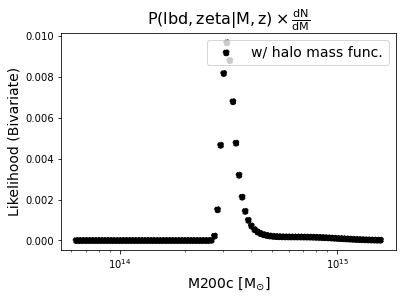

In [35]:
# plt.loglog()
plt.scatter(mvec,p_total_m[:,0],label='w/ halo mass func.',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood (Bivariate)',fontsize=14)
plt.title(r'$\rm P(lbd, zeta| M, z) \times \frac{dN}{dM}$', fontsize=16)
plt.legend(fontsize=14)

In [36]:
# SAME ISSUE WITH OPERANDS NOT BEING ABLE TO BROADCAST

# # forgot the mass
# redshift_i = redshift[ix]
# p_chisi = prob_chisi_vec[ix]
# p_lbd_hat = prob_lbd_hat_vec[ix]
# #p_lbd_hat_conv = prob_lbd_hat_conv[ix]
# for x, y in list(lbd_indices_vec[ix]):
#     llo, lup = x, y
# #llo, lup = 0, len(lbdvec)#list(lbd_indices_vec[ix])
# for x, y in list(zeta_indices_vec[ix]):
#     clo, cup = x, y
    
# A_lambda, B_lambda, C_lambda, scatter_lambda = theta_true[4:8]
# A_sze, B_sze, C_sze, scatter_sze = theta_true[:4]
# rho = theta_true[-1]

# # calling predictions;
# ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, redshift_i)
# ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, redshift_i)
# halo_mass_func = halo_mass_function2(redshift_i)

# ln_lbd_pred = ln_lbd_pred[:,np.newaxis,np.newaxis]
# ln_zeta_pred= ln_zeta_pred[:,np.newaxis,np.newaxis]
# hmf = halo_mass_func[:,np.newaxis,np.newaxis]

# current_lp_total_m = compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
#                          ln_lbd_pred, ln_zeta_pred, eps = 1e-9)
